In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

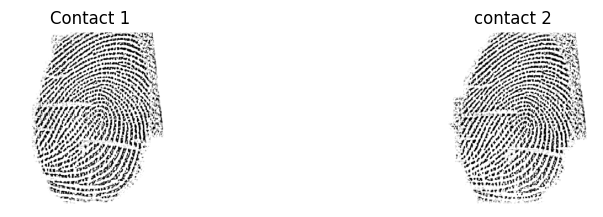

In [5]:
contact_image_raw_1 = cv2.imread('../PolyU/contact-based_fingerprints/first_session/1_1.jpg')
contact_image_gray_1 = cv2.cvtColor(contact_image_raw_1, cv2.COLOR_BGR2GRAY)

contact_image_raw_2 = cv2.imread('../PolyU/contact-based_fingerprints/first_session/1_2.jpg')
contact_image_gray_2 = cv2.cvtColor(contact_image_raw_2, cv2.COLOR_BGR2GRAY)
# contact_image_gray_2 = cv2.flip(contact_image_gray_2, 0)
# contact_image_gray_2 = cv2.rotate(contact_image_gray_2, cv2.ROTATE_90_COUNTERCLOCKWISE)


plt.figure(figsize=(10, 5))

plt.subplot(2, 2, 1)
plt.imshow(contact_image_gray_1, cmap='gray')
plt.title('Contact 1')
plt.axis('off')

plt.subplot(2, 2, 2)
plt.imshow(contact_image_gray_2, cmap='gray')
plt.title('contact 2')
plt.axis('off')
plt.show()

((<DMatch 0x7f6d2d21bcb0>, <DMatch 0x7f6d2d141490>), (<DMatch 0x7f6d2d1414f0>, <DMatch 0x7f6d2d141370>), (<DMatch 0x7f6d2d1414d0>, <DMatch 0x7f6d2d1d9250>), (<DMatch 0x7f6d2d1d9350>, <DMatch 0x7f6d2d1d9950>), (<DMatch 0x7f6d2d1d90d0>, <DMatch 0x7f6d2d1d9810>), (<DMatch 0x7f6d2c05eb50>, <DMatch 0x7f6d2c05ed70>), (<DMatch 0x7f6d2c05ee30>, <DMatch 0x7f6d2c05ecb0>), (<DMatch 0x7f6d2c05eed0>, <DMatch 0x7f6d2c05ea10>), (<DMatch 0x7f6d2c05edf0>, <DMatch 0x7f6d2c05ed50>), (<DMatch 0x7f6d2c05e910>, <DMatch 0x7f6d2c05ee70>), (<DMatch 0x7f6d2c05ec90>, <DMatch 0x7f6d2c05edd0>), (<DMatch 0x7f6d2c05ea90>, <DMatch 0x7f6d2c05eef0>), (<DMatch 0x7f6d2c05ef90>, <DMatch 0x7f6d2c05eab0>), (<DMatch 0x7f6d2c05e9f0>, <DMatch 0x7f6d2c05ecd0>), (<DMatch 0x7f6d2c05ed10>, <DMatch 0x7f6d2c05ee90>), (<DMatch 0x7f6d2c05ee50>, <DMatch 0x7f6d2c05eaf0>), (<DMatch 0x7f6d2c05ef50>, <DMatch 0x7f6d2c05ef30>), (<DMatch 0x7f6d2c05ecf0>, <DMatch 0x7f6d2c05e7d0>), (<DMatch 0x7f6d2c05ebd0>, <DMatch 0x7f6d2c06f190>), (<DMatch 0x

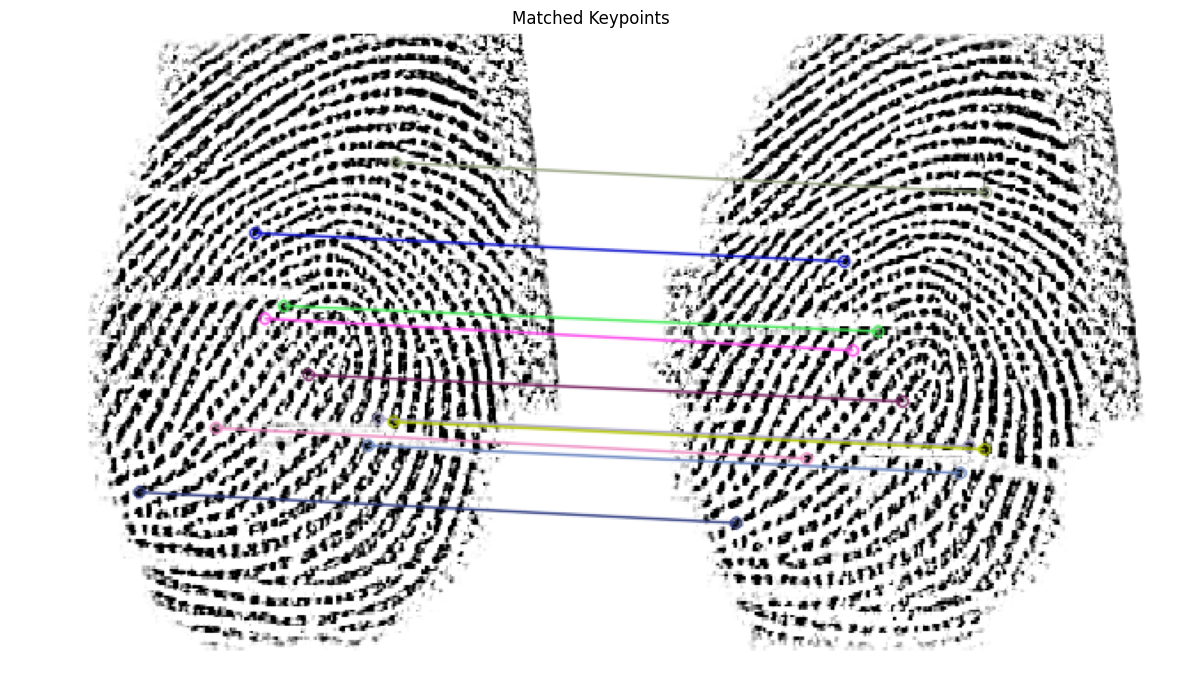

length 10
Not enough matches found to align images


In [6]:
def align_fingerprints(img1, img2):
    # Step 1: Convert images to grayscale
    # gray1 = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY)
    # gray2 = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY)
    
    # Step 2: Detect ORB key points and descriptors
    orb = cv2.ORB_create()
    kp1, des1 = orb.detectAndCompute(img1, None)
    kp2, des2 = orb.detectAndCompute(img2, None)
    
    # Step 3: Match key points using FLANN matcher
    index_params = dict(algorithm=6, table_number=6, key_size=12, multi_probe_level=2)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)
    
    matches = flann.knnMatch(des1, des2, k=2)
    print(matches)
    # Filter matches using Lowe's ratio test
    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    matched_image = cv2.drawMatches(img1, kp1, img2, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    
    # Display matched keypoints
    plt.figure(figsize=(15, 10))
    plt.title('Matched Keypoints')
    plt.imshow(cv2.cvtColor(matched_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()
    # matchesMask = [[0,0] for i in range(len(matches))]
 
    # # ratio test.
    # for i,(m,n) in enumerate(matches):
    #     if( m.distance < 0.1*n.distance):
    #         matchesMask[i]=[1,0]
    # draw_params = dict(matchColor = (0,255,0),
    #                    singlePointColor = (255,0,0),
    #                    matchesMask = matchesMask,flags = 0)
     
    # # drawing nearest neighbours
    # img = cv.drawMatchesKnn(main_image,
    #                         key_point1,
    #                         sub_image,
    #                         key_point2,
    #                         matches,
    #                         None,
    #                         **draw_params)
    # return img
    
    # Check if enough matches are found
    MIN_MATCH_COUNT = 10
    print('length', len(good_matches))
    if len(good_matches) > MIN_MATCH_COUNT:
        # Extract locations of good matches
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        
        # Step 4: Compute homography
        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        
        # Step 5: Warp one image to align with the other
        h, w = img1.shape[:2]
        aligned_img = cv2.warpPerspective(img1, M, (w, h))
        print(M,w, h)
        # Display the aligned image and the original for comparison
        plt.figure(figsize=(10, 5))
        plt.subplot(1, 2, 1)
        plt.title('Original Image')
        plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
        
        plt.subplot(1, 2, 2)
        plt.title('Aligned Image')
        plt.imshow(cv2.cvtColor(aligned_img, cv2.COLOR_BGR2RGB))
        
        plt.show()
        return aligned_img
    else:
        print("Not enough matches found to align images")
        return None


aligned_image = align_fingerprints(contact_image_gray_1, contact_image_gray_2)

(225, 350, 3)
(225, 350, 3)


(-0.5, 349.5, 224.5, -0.5)

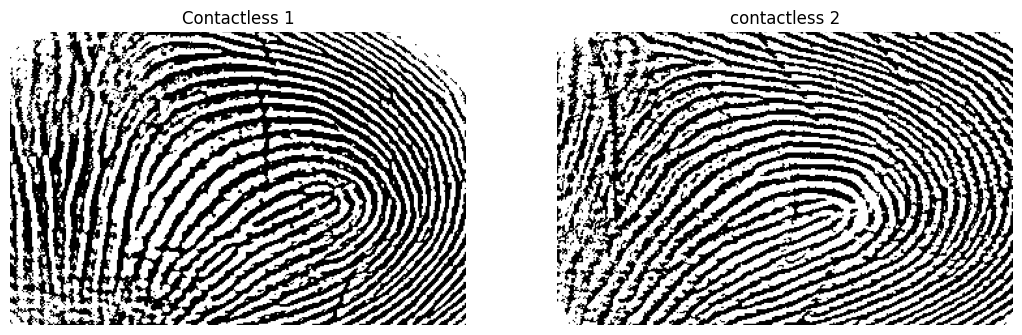

In [7]:
# Pre-Processing for contactless 1
contactless_image_raw = cv2.imread('../PolyU/processed_contactless_2d_fingerprint_images/first_session/p1/p1.bmp')
print(np.shape(contactless_image_raw))
contactless_image_gray = cv2.cvtColor(contactless_image_raw, cv2.COLOR_BGR2GRAY)

# Histogram Equi
equilized_image = cv2.equalizeHist(contactless_image_gray)
# AMT
AMT_image_1 = cv2.adaptiveThreshold(equilized_image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

#gabor
ksize = 21  # Size of the Gabor kernel
sigma = 5.0  # Standard deviation of the Gaussian envelope
theta = 0  # Orientation of the normal to the parallel stripes
lambd = 10.0  # Wavelength of the sinusoidal factor
gamma = 0.5  # Spatial aspect ratio
phi = 0  # Phase offset

# Generate Gabor kernel
gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
gabor_filtered_1 = cv2.filter2D(AMT_image_1, cv2.CV_8UC3, gabor_kernel)

# Pre-processing for contactless 2
contactless_image_raw = cv2.imread('../PolyU/processed_contactless_2d_fingerprint_images/first_session/p2/p1.bmp')
print(np.shape(contactless_image_raw))
contactless_image_gray = cv2.cvtColor(contactless_image_raw, cv2.COLOR_BGR2GRAY)

# Histogram Equi
equilized_image = cv2.equalizeHist(contactless_image_gray)
# AMT
AMT_image_2 = cv2.adaptiveThreshold(equilized_image,255,cv2.ADAPTIVE_THRESH_MEAN_C,cv2.THRESH_BINARY,11,2)

#gabor
ksize = 21  # Size of the Gabor kernel
sigma = 5.0  # Standard deviation of the Gaussian envelope
theta = 0  # Orientation of the normal to the parallel stripes
lambd = 10.0  # Wavelength of the sinusoidal factor
gamma = 0.5  # Spatial aspect ratio
phi = 0  # Phase offset

# Generate Gabor kernel
gabor_kernel = cv2.getGaborKernel((ksize, ksize), sigma, theta, lambd, gamma, phi, ktype=cv2.CV_32F)
gabor_filtered_2 = cv2.filter2D(AMT_image_2, cv2.CV_8UC3, gabor_kernel)

plt.figure(figsize=(20, 15))

plt.subplot(2, 3, 1)
plt.imshow(AMT_image_1, cmap='gray')
plt.title('Contactless 1')
plt.axis('off')

plt.subplot(2, 3, 2)
plt.imshow(AMT_image_2, cmap='gray')
plt.title('contactless 2')
plt.axis('off')

((<DMatch 0x7f6d2404dc70>, <DMatch 0x7f6d2d1d9350>), (<DMatch 0x7f6d2c05ef10>, <DMatch 0x7f6d2c05eb50>), (<DMatch 0x7f6d2c05ed70>, <DMatch 0x7f6d2c05edf0>), (<DMatch 0x7f6d2c05eeb0>, <DMatch 0x7f6d2c05ea90>), (<DMatch 0x7f6d045dd330>, <DMatch 0x7f6d045dd650>), (<DMatch 0x7f6d045dd6d0>, <DMatch 0x7f6d045dd170>), (<DMatch 0x7f6d045dd430>, <DMatch 0x7f6d045dd390>), (<DMatch 0x7f6d045dd470>, <DMatch 0x7f6d045dd1f0>), (<DMatch 0x7f6d045dd2b0>, <DMatch 0x7f6d045dd590>), (<DMatch 0x7f6d045dd450>, <DMatch 0x7f6d045dd5d0>), (<DMatch 0x7f6d045dd7d0>, <DMatch 0x7f6d045dd850>), (<DMatch 0x7f6d045dd9d0>, <DMatch 0x7f6d045dd250>), (<DMatch 0x7f6d045dd290>, <DMatch 0x7f6d045dd570>), (<DMatch 0x7f6d045dd8d0>, <DMatch 0x7f6d045dd830>), (<DMatch 0x7f6d045dd8f0>, <DMatch 0x7f6d045dd670>), (<DMatch 0x7f6d045dd7f0>, <DMatch 0x7f6d045dd910>), (<DMatch 0x7f6d045dd810>, <DMatch 0x7f6d045dd410>), (<DMatch 0x7f6d045dd990>, <DMatch 0x7f6d045dda90>), (<DMatch 0x7f6d045dd310>, <DMatch 0x7f6d045dd610>), (<DMatch 0x

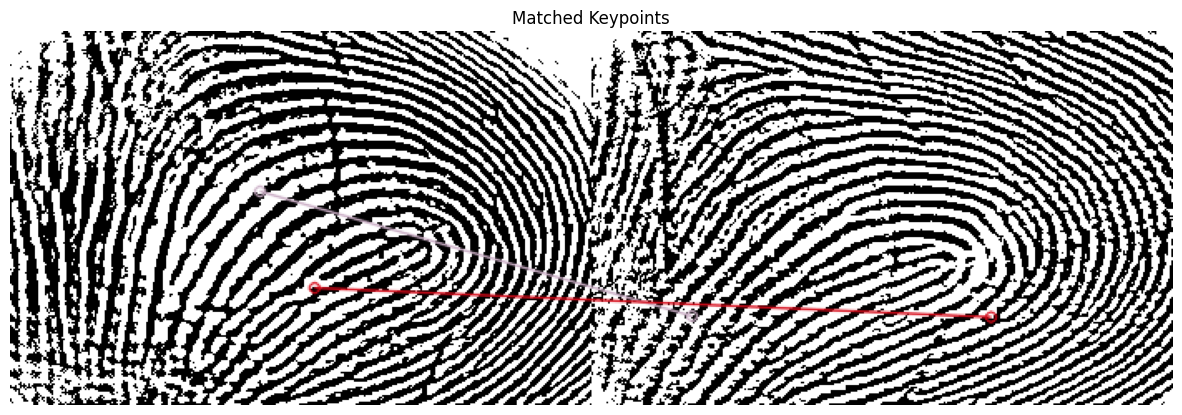

length 2
Not enough matches found to align images


In [8]:
aligned_image = align_fingerprints(AMT_image_1, AMT_image_2)